In [20]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import time

## Model Configuration

In [21]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class ModelArgs:
    dim: int = 128
    n_layers: int = 2
    n_heads: int = 4
    n_kv_heads: Optional[int] = None
    vocab_size: int = -1  # defined later by tokenizer
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5

    max_batch_size: int = 32
    max_seq_len: int = 16 * 8

    epochs: int = 5_000    

model_config = ModelArgs()
print(model_config)

ModelArgs(dim=128, n_layers=2, n_heads=4, n_kv_heads=None, vocab_size=-1, multiple_of=256, ffn_dim_multiplier=None, norm_eps=1e-05, max_batch_size=32, max_seq_len=128, epochs=5000)


## Prepare Data

In [22]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])


lines = open('./data/Shakespeare.txt', 'r').read()
vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}
dataset = torch.tensor(encode(lines), dtype=torch.int8)
print(f'Sentences: {dataset.shape[0]}')

model_config.vocab_size = len(vocab)

def get_batches(data, split, batch_size, context_window):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    if split == 'train':
        batch_data = train
    elif split == 'test':
        batch_data = test
    else:
        batch_data = val

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

Sentences: 1115394


## Define Models

### RMS Normalization 

- [Paper](https://arxiv.org/pdf/1910.07467.pdf)
- [Reference implementation](https://github.com/facebookresearch/llama/blob/54d44631054deae836aec8ceff92dcf8f20ca9e7/llama/model.py#L34)

In [23]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """
        Initialize the RMSNorm normalization layer.

        Args:
            dim (int): The dimension of the input tensor.
            eps (float, optional): A small value added to the denominator for numerical stability. Default is 1e-6.

        Attributes:
            eps (float): A small value added to the denominator for numerical stability.
            weight (nn.Parameter): Learnable scaling parameter.

        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x : torch.tensor) -> torch.tensor:
        """
        Apply the RMSNorm normalization to the input tensor.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The normalized tensor.

        """
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x) -> torch.tensor:
        """
        Forward pass through the RMSNorm layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying RMSNorm.

        """        
        return self._norm(x.float()).type_as(x) * self.weight

### RoPE

- [Paper](https://arxiv.org/pdf/2104.09864.pdf)
- [Reference Implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L80)

In [24]:
class RoPE:
    def __init__(self, dim: int, max_seq_len: int, theta: float = 10000.0):
        """
        Precompute the frequency tensor for complex exponentials (cis, defined as 'm*theta_i' in the paper) 
        with given dimensions.

        Calculates a frequency tensor with complex exponentials using the given dimension 'dim'
        and the max sequence length. The 'theta_base' parameter scales the frequencies.
        The returned tensor contains complex values in complex64 data type.

        Args:
            dim (int): Dimension of the frequency tensor.
            max_seq_len (int): Max sequence length.
            theta_base (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.
        """
        freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
        freqs = torch.outer(torch.arange(max_seq_len), freqs).float()
        self.freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
        print(f'Initialized RoPE with shape {self.freqs_cis.shape}')
        
    def __call__(self, x: torch.Tensor, start_pos = 0) -> torch.Tensor:
        """
        Apply rotary embeddings to input tensors using the given frequency tensor.

        This function first reshapes the frequency tensor to have the same shape as the target tensor 'x'
        for the purpose of broadcasting the frequency tensor during element-wise operations. Then, it applies 
        rotary embeddings to 'x' tensor using frequency tensor 'freqs_cis'.         
        """
        x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))

        # shape = [d if i == 1 or i == x.ndim - 1 else 1 for i, d in enumerate(x_complex.shape)]
        freqs_cis = self.freqs_cis[start_pos:start_pos + x.shape[-2]]
                
        x_real = torch.view_as_real(x_complex * freqs_cis).flatten(-2)
        
        return x_real.type_as(x)

#### RoPE Test

In [25]:
dim = 128
max_seq_len = 256

def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*i / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

R = get_rotary_matrix(max_seq_len, dim)

X= torch.ones(1, max_seq_len, dim)
rope = RoPE(dim=dim, max_seq_len=max_seq_len)
X1 = rope(X)
X2 = (R @ X.unsqueeze(-1)).flatten(-2)

print(X1.allclose(X2, atol=1e-3))


Initialized RoPE with shape torch.Size([256, 64])
True


### Feed-Forward Networks with SwiGLU

- [Paper](https://arxiv.org/pdf/2002.05202.pdf)
- [Reference Implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L307)

In [26]:
from typing import Optional

class FFN_SwiGLU(nn.Module):
    def __init__(
            self,
            dim: int,
            hidden_dim: int,
            multiple_of: int,
            ffn_dim_multiplier: Optional[float],
        ):
        """
        Args:
            dim (int): Input dimension.
            hidden_dim (int): Hidden dimension of the feedforward layer.
            multiple_of (int): Value to ensure hidden dimension is a multiple of this value.
            ffn_dim_multiplier (float, optional): Custom multiplier for hidden dimension. Defaults to None.

        Attributes:
            w1 (ColumnParallelLinear): Linear transformation for the first layer.
            w2 (RowParallelLinear): Linear transformation for the second layer.
            w3 (ColumnParallelLinear): Linear transformation for the third layer.

        """
        super().__init__()
        hidden_dim = int(2 * hidden_dim / 3)
        # custom dim factor multiplier
        if ffn_dim_multiplier is not None:
            hidden_dim = int(ffn_dim_multiplier * hidden_dim)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w = nn.Linear(dim, hidden_dim, bias=False)
        self.v = nn.Linear(dim, hidden_dim, bias=False)
        self.w_2 = nn.Linear(hidden_dim, dim, bias=False)

    def forward(self, x):
        return self.w_2(F.silu(self.w(x)) * self.v(x))

### Attention

In [27]:
class Attention(nn.Module):
    shared_rope : RoPE = None

    def __init__(self, config : ModelArgs):
        super().__init__()
        self.config = config
        if Attention.shared_rope is None:
            Attention.shared_rope = RoPE(config.dim, config.max_seq_len)

        self.w_q = nn.Linear(config.dim, config.dim, bias=False)
        self.w_k = nn.Linear(config.dim, config.dim, bias=False)
        self.w_v = nn.Linear(config.dim, config.dim, bias=False)

        self.cache_k = torch.zeros(config.max_batch_size, config.max_seq_len, config.dim, requires_grad=False)
        self.cache_v = torch.zeros_like(self.cache_k, requires_grad=False)

    def forward(self, x: torch.tensor, start_pos : int) -> torch.tensor:
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q = Attention.shared_rope(q, start_pos)
        k = Attention.shared_rope(k, start_pos)        

        if self.training:       # apply dropout only during training
            dropout_p = 0.1            
        else:            
            self.cache_k[:, start_pos:start_pos + x.shape[-2]] = k
            self.cache_v[:, start_pos:start_pos + x.shape[-2]] = v        
            k = self.cache_k[:, :start_pos + x.shape[-2]]
            v = self.cache_v[:, :start_pos + x.shape[-2]]

            dropout_p = 0
        
        if x.shape[-2] == 1:    # if only one token, then not causal            
            is_causal = False
        else:
            is_causal = True

        activations = F.scaled_dot_product_attention(q, k, v, 
                                                     dropout_p = dropout_p, 
                                                     is_causal = is_causal)

        return activations


class MultiheadAttention(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            Attention(config) for _ in range(config.n_heads)
        ])
        self.linear = nn.Linear(config.n_heads * config.dim, config.dim)
        self.dropout = nn.Dropout(.1)

    def forward(self, x : torch.tensor, start_pos : int) -> torch.tensor:
        h_heads = [head(x, start_pos) for head in self.heads]
        h = torch.cat(h_heads, dim=-1)
        h = self.linear(h)
        h = self.dropout(h)

        return h

In [28]:
from collections import OrderedDict

class Llama2Block(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config

        self.rms = RMSNorm(config.dim)

        self.attention = MultiheadAttention(config)
        self.attention_norm = RMSNorm(config.dim, eps = config.norm_eps)
        self.ffn_norm = RMSNorm(config.dim, eps = config.norm_eps)
        self.ffn_swiglu = FFN_SwiGLU(config.dim, config.dim * 4, config.multiple_of, config.ffn_dim_multiplier)

    def forward(self, x, start_pos) -> torch.tensor:
        x = x + self.attention(self.attention_norm(x), start_pos)
        out = x + self.ffn_swiglu(self.ffn_norm(x))

        return out

class Llama2(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        
        Attention.shared_rope = None    # clear the shared rope defined in Attention class

        self.config = config
        self.embeddings = nn.Embedding(config.vocab_size, config.dim)
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"LlamaBlock_{i}", Llama2Block(config)) for i in range(config.n_layers)])
        )
        self.norm = RMSNorm(config.dim)
        self.output = nn.Linear(config.dim, config.vocab_size, bias=False)

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, start_pos = 0, targets = None):
        h = self.embeddings(idx)

        for block in self.llama_blocks:
            h = block(h, start_pos)

        h = self.norm(h)
        logits = self.output(h)

        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))
            return logits, loss

## Training

In [29]:
import pandas as pd

@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model:Llama2):
    config = model.config
    out = {}
    is_training = model.training

    if is_training:
        model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config.max_batch_size, config.max_seq_len)
            _, loss = model(xb, 0, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    if is_training:
        model.train()

    return out

def train(model: Llama2, optimizer:torch.optim.Optimizer, scheduler = None, print_logs = False, log_interval = 100):
    losses = []
    start_time = time.time()
    config = model.config
    for epoch in range(config.epochs):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config.max_batch_size, config.max_seq_len)
        _, loss = model(xs, 0, ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
        
        if epoch % log_interval == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config.epochs - epoch)/log_interval :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())            

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

Initialized RoPE with shape torch.Size([128, 64])
model params: 935296


Epoch 0 | val loss 3.964 | Time 0.247 | ETA in seconds 12.371
Epoch 100 | val loss 2.188 | Time 11.544 | ETA in seconds 565.645
Epoch 200 | val loss 1.955 | Time 11.373 | ETA in seconds 545.888
Epoch 300 | val loss 1.871 | Time 13.505 | ETA in seconds 634.756
Epoch 400 | val loss 1.792 | Time 14.480 | ETA in seconds 666.089
Epoch 500 | val loss 1.715 | Time 15.143 | ETA in seconds 681.449
Epoch 600 | val loss 1.680 | Time 15.642 | ETA in seconds 688.253
Epoch 700 | val loss 1.658 | Time 15.602 | ETA in seconds 670.907
Epoch 800 | val loss 1.658 | Time 16.059 | ETA in seconds 674.458
Epoch 900 | val loss 1.623 | Time 15.926 | ETA in seconds 652.951
Epoch 1000 | val loss 1.627 | Time 15.987 | ETA in seconds 639.468
Epoch 1100 | val loss 1.597 | Time 16.139 | ETA in seconds 629.427
Epoch 1200 | val loss 1.629 | Time 15.082 | ETA in seconds 573.112
Epoch 1300 | val loss 1.603 | Time 14.685 | ETA in seconds 543.357
Epoch 1400 | val loss 1.585 | Time 16.344 | ETA in seconds 588.391
Epoch 150

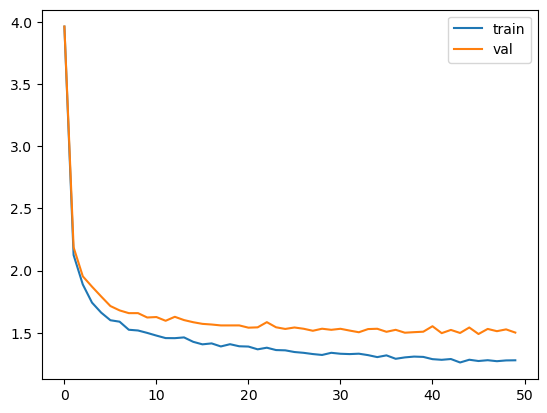

In [30]:
%%time

from datetime import datetime

llama = Llama2(model_config)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, print_logs=True)

# Save
now = datetime.now()
model_name = f'./checkpoint/llama2_L{model_config.n_layers}xH{model_config.n_heads}xC{model_config.max_seq_len}_{now.year}_{now.month}_{now.day}_{now.hour}_{now.minute}.pth'
torch.save({'model_state_dict': llama.state_dict()}, model_name)

## Generate

In [31]:
@torch.no_grad()
def generate(model : Llama2, max_new_tokens = 10):
    model.eval()
    config = model.config
    max_new_tokens = model.config.max_seq_len if max_new_tokens > model.config.max_seq_len else max_new_tokens
    idx = torch.zeros(config.max_batch_size, 1).long()

    start_pos = 0
    for i in range(max_new_tokens):
        if i == 0:
            logits = model(idx)
        else:
            logits = model(idx[:, -1].unsqueeze(-1), start_pos)
            # logits = model(idx[:, -config.max_seq_len:], 0)
        
        last_time_step_logits = logits[:, -1, :]            # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)        # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )                                                   # sample from the distribution to get the next token

        start_pos = idx.shape[-1]
        idx = torch.cat([idx, idx_next], dim=-1)            # append to the sequence
                    
    return [decode(x) for x in idx.tolist()]

In [32]:
import glob
import os

## Get lastest checkpoint
files = glob.glob('./checkpoint/*.pth')
files.sort(key=os.path.getmtime)
model_name = files[-1]

llama_infer = Llama2(model_config)
llama_infer.load_state_dict(torch.load(model_name)['model_state_dict'])

Initialized RoPE with shape torch.Size([128, 64])
model params: 935296


<All keys matched successfully>

In [33]:
%%time

for s in generate(llama_infer, 100):
    print(s)



weeping branch; the earth on, may may;
And in thy sons command faith hath doubt a truth
Becomest
In

Say, fearful honour, from then you not a last?

Nurse:
No, weary could not tell it were it.

ROMEO:


speak that, peace of Paulina?

JULIET:
But my renownly banished'? with good old hands!
Faith, For an

The ousin! whose head, for success reely
Than this harses, and yet the many of heart owes.

CORIOLAN



MENENIUS:
Pray forward Henry; I know't.

ANGELO:
He hatreor the is like Fruth, whither came or wro

And come to the Tower.

ROMEO:
Then, ere, I may stand foence:
Prove I thee how cut me: come in here 


KING RICHARD II:
Not take Hy sake, nor as common to hot
In this more utterix, a tay beggar,
I drivi

I am Rost sun, one her bloody of the good
Diress to be dispatch'd thee the measure's friends, and le

This purse the wealth news while, what thou sir:
Then, that tempter with the times were shall know't

But I have a king! Coriolanus, what, lords,

ANGELO:

CLARENCE:
Alas,
Sweet time 